# Solar plane optimization
The goal of this notebook is to determine if a solar plane can sustain flight, and if it can, figure out what the cheapest solar plane that can sustain flight is.

The approach is to first make a model of a solar plane that can be fed different parameters about the plane (wingspan, battery mass, cruising altitude, number of props, payload mass, etc). With this model, we can then feed in different plane configutations and figure out which configuration leads to the optimal results.

The plane is assumed to be a flying wing (like these https://www.google.com/search?q=flying+wing&safe=off&source=lnms&tbm=isch), since this is generally the lowest drag configuration possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate, optimize, constants

from numba import jit # Without numba, the model runs very slowly

import airmass

pd.set_option('max_columns', 99)
%matplotlib inline

In [2]:
# TODO

# Sun following - if plane flies toward the sun, it can effectively get a slightly longer day
# Wind speed vs. altitude, related to above
# Add structural calculations for weight of craft and prop, seems difficult

Relevant papers
 - Noth 2008 - Design of Solar Powered Airplanes for Continuous Flight: http://www.sky-sailor.ethz.ch/docs/Thesis_Noth_2008.pdf
 - Leutenegger 2014 - Unmanned Solar Airplanes: Design and Algorithms for Efficient and Robust Autonomous Operation: https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/90524/eth-46751-02.pdf

### Parameters
These are the constants and bounds that we feed into the optimization.

In [3]:
# SolidEnergy Hermes: http://www.solidenergysystems.com/hermes/
battery_specific_energy = 415 # Wh/kg - design for a lower specific energy even though rated for 450 Wh/kg
battery_cell_mass = 0.029 # kg
battery_cell_nominal_voltage = 3.7 # V
battery_high_water_mark = 0.05 # Can charge battery to 95% at winter solstice. Leaves room for lost capacity
battery_low_water_mark = 0.08 # Don't deplete battery under 8% for reserve power

# .036 for digital, .11 for AC: http://batteryuniversity.com/learn/article/how_to_measure_internal_resistance
battery_cell_internal_resistance = 0.11 # Ohms

motor_specific_power = 5000 # W/kg

# Most MPPTs on the market have 95-99% efficiency
mppt_efficiency = 0.98

# Brushless motors typically have 95-98% efficiency
motor_efficiency = 0.97

# Other losses in wires and electronics
processing_efficiency = 0.96

prop_mass_per_diameter = 0.5 # kg / m / prop

max_prop_ratio = 0.9 # Max fraction of span propellers take up

solar_wing_coverage = 0.96 # Fraction of wing covered in solar cells
solar_cell_mass_per_area = 0.2686 # 30g / (219mm * 510mm)

avionics_power = 5 # W

# Inmarsat SB-UAV: https://www.inmarsat.com/wp-content/uploads/2016/09/Inmarsat_Global_Government_SB-UAV-_June_2017_EN_lowres.pdf
satcom_mass = 1.45 # kg
satcom_power = 28.0 # W
satcom_duty_cycle = 0.1 # 10% duty cycle

# IAI MiniPOP: https://www.iai.co.il/p/minipop
payload_mass = 8.0 # kg
payload_power = 80.0 # W, this is a guess

# POP300D: https://starkaerospace.com/products-services/sensors/pop300/
# payload_mass = 16.3 # kg
# payload_power = 120.0 # W


# 3-5AM and 10AM-4PM usage
payload_usage_1_start = 3.0
payload_usage_1_end = 5.0
payload_usage_2_start = 10.0
payload_usage_2_end = 16.0

max_max_engine_power = 50 * motor_specific_power # 50 kg motor max
max_props = 30

# The lower the min altitude, the more gravitational potential energy can be stored
min_altitude = 1000
max_altitude = 50000

day_of_year = 355
latitude = 40

nt = 2000 # Time steps over 1 day

likely_region = {
    'starting_altitude': (min_altitude, max_altitude),
    'battery_starting_energy_frac': (0.3, 0.7),
    'battery_mass': (1, max_max_engine_power * max_props * 0.1 / battery_specific_energy),
    'prop_diameter': (0.1, 10.0),
    'wing_area': (1, 100),
    'sweep_angle': (0, np.pi / 4),
    'aspect_ratio': (3, 20),
    'num_props': (4, 12), # At least two props for redundancy
    'num_pusher_props': (0, 12),
    # Engine power constants
    # They define engine power throughout the day
    'e1': (1, max_max_engine_power / 30),
    'e2': (0, 400),
    'e3': (0, 5),
    'e4': (0, 12),
    'e5': (0, 30),
    'e6': (0, 20),
    # Airspeed constants
    # They define airspeed throughout the day
    'a1': (1, 50),
    'a2': (0, 20),
    'a3': (0, 3),
    'a4': (0, 15),
    'a5': (0, 3),
    'a6': (0, 20),
}

bounds = {
    'starting_altitude': (min_altitude, max_altitude),
    'battery_starting_energy_frac': (0.1, 0.8),
    'battery_mass': (1, max_max_engine_power * max_props * 14 / battery_specific_energy),
    'prop_diameter': (0.1, 10.0),
    'wing_area': (0.01, 1000),
    'sweep_angle': (0, np.pi / 2 * 0.99),
    'aspect_ratio': (0.01, 50),
    'num_props': (1, max_props),
    'num_pusher_props': (0, max_props),
    # Engine power constants
    'e1': (1, max_max_engine_power / 2),
    'e2': (0, max_max_engine_power / 2),
    'e3': (1, 24),
    'e4': (-3600 * 12, 3600 * 12),
    'e5': (0, 100),
    'e6': (0, 24),
    # Airspeed constants
    'a1': (1, 150),
    'a2': (0, 150),
    'a3': (0, 100),
    'a4': (0, 24),
    'a5': (0, 100),
    'a6': (0, 24)
}

### Constants

In [4]:
R = 8314.46 # J/(kmol*K)
gamma = 1.40 # air
M = 28.895 # kg/kmol, air
gravitational_constant = 6.674e-11
earth_mass = 5.972e24 # kg
earth_radius = 6375000 # m

# Atmospheric data
# From http://www.digitaldutch.com/atmoscalc/tableatmosphere.htm
atm_data = pd.read_csv('st_atm_1976.csv').set_index('Altitude [m]')
atmosphere = atm_data.reindex(np.arange(atm_data.index[0], atm_data.index[-1] + 1)).interpolate().values

T_ground, P_ground, rho_ground, c_ground, u_ground = atmosphere[0]

#### Prepare the solar irradiance at different altitudes and times of day
We pre-calculate the solar irradiance rather than calculating the solar irradiance itself
every time it runs. We use the [Python airmass module](https://github.com/gusgordon/airmass).

Different profiles can be generated with generate_irradiance_graph.ipynb.

In [5]:
solar_graph = pd.read_csv(f'solar_graph_day_{day_of_year}_lat_{latitude}.csv', index_col='second').values

@jit
def solar_irradiance(altitude, second_of_day):
    altitude = max(altitude, 0)
    return solar_graph[int(round(second_of_day / 60)), int(round(altitude / 25))]

### Wing, propeller thrust, etc. functions

In [6]:
# Compute the coefficient of drag of the given wing
# Note this is just the drag due to lift, ie pushing air down below the wing to support the airplane
# This also supports the supersonic case, but I don't think that will be useful here :)
@jit
def swept_wing(Cl, wing_area, aspect_ratio, sweep_angle, Ma):
    max_wingspan = 500 # meters

    # Supersonic case, treat the wing as a yawed ellipse. Still need a, b for subsonic
    # https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19760011971.pdf p. 661
    psi = np.pi / 2 - sweep_angle
    a_prime = 2 * np.sqrt(wing_area) / (np.pi * np.sqrt(aspect_ratio))
    b_prime = np.sqrt(wing_area * aspect_ratio) / 2

    # Solve for b given a', b', and angle of yaw
    # http://bit.ly/2lY0T04, 4th solution
    if b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2 > 0:
        within = b_prime ** 2 + np.sqrt(b_prime ** 2 * (b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2))
        b = np.sqrt((1 / np.sin(psi))**2 * within) / np.sqrt(2)
    else:
        return 1e50, 1, 1, 1

    a = a_prime * b_prime / b
    wingspan = b_prime * 2

    # Confirm wing planform is physically possible
    if wingspan > max_wingspan:
        return 1e50, 1, 1, 1

    # Subsonic induced drag
    # http://www.fzt.haw-hamburg.de/pers/Scholz/OPerA/OPerA_PUB_DLRK_12-09-10.pdf
    if sweep_angle > np.pi / 6: # > 30 degrees, swept wing (Raymer)
        e = 4.61 * (1 - 0.045 * aspect_ratio ** 0.68) * np.cos(sweep_angle) ** 0.15 - 3.1
    else: # Unswept wing (Raymer)
        e = 1.78 * (1 - 0.045 * aspect_ratio ** 0.68) - 0.64
    if e < 0:
        return 1e50, 1, 1, 1

    Cd_Cl2 = 1 / (np.pi * e * aspect_ratio)

    # Karman-Tsien compressibility correction
    beta = np.sqrt(np.abs(1 - Ma ** 2))
    Cd_Cl2 = Cd_Cl2 / (beta + Ma ** 2 / (1 + beta) * Cd_Cl2 / 2)

    # Supersonic pressure drag
    if Ma > 1:
        m = (b ** 2 - a ** 2) * np.sin(psi) * np.cos(psi) / b_prime ** 2

        # There is a mistake in Jones' formula, a and b should be primed
        Cd_Cl2 += 1 / 4 * np.sqrt(Ma ** 2 - 1 - (m + 1j * a_prime / b_prime) ** 2).real

    Cd = Cd_Cl2 * Cl ** 2

    min_wing_dimension = min(a, b)
    wing_length = a_prime * 2

    return Cd, min_wing_dimension, wing_length, wingspan


# Compute drag. The two sources of drag here are lift induced drag and skin friction drag.
# Lift induced drag is computed from the output of swept_wing, skin friction drag is
# the drag due to air rubbing against the wing.
@jit
def compute_drag(rho=0, v=0, c=0, L=0, dynamic_viscosity=0, T=0, p=0,
                 wing_area=0, sweep_angle=0, aspect_ratio=0, prop_turb_length=0):
    # Compute drag on a subsonic plane

    Ma = v / c

    ## Lift induced drag
    Cl = 2 * L / (wing_area * rho * v ** 2) # Calculate required Cl
    Cd, min_wing_dimension, wing_length, wingspan = swept_wing(Cl, wing_area, aspect_ratio, sweep_angle, Ma)
    induced_drag = 0.5 * Cd * wing_area * rho * v ** 2

    ## Skin friction drag
    # http://mail.tku.edu.tw/095980/drag.pdf
    # Assume boundary layer is turbulent, which also leads to pressure drag being negligible
    Re = v * wing_length * rho / dynamic_viscosity
    Twall = T * (1 + 0.178 * Ma**2)
    Tprime = T * (1 + 0.035 * Ma**2 + 0.45 * (Twall / T - 1))
    Reprime = Re * (((T + 120) / (Tprime + 120)) * (T / Tprime) ** 1.5)

    # Laminar: https://ipfs.io/ipfs/QmXoypizjW3WknFiJnKLwHCnL72vedxjQkDDP1mXWo6uco/wiki/Skin_friction.html
    Cfprime_lam = 1.328 / np.sqrt(Reprime)
    Cfprime_lam = Cfprime_lam * 1.04 # Roughness and gap scaling
    Cf_lam = T / Tprime * Cfprime_lam

    # Turbulent
    Cfprime_turb = 0.455 / np.log10(Reprime) ** 2.58
    Cfprime_turb = Cfprime_turb * 1.07 # Roughness and gap scaling
    Cf_turb = T / Tprime * Cfprime_turb

    # Fraction of laminar flow over the wing = non-prop span * frac of downwash (over non-prop span) that's laminar
    turb_span_frac = prop_turb_length / wingspan
    lam_span_frac = 1 - turb_span_frac
    lam_turb_transition_loc = 5e5 * dynamic_viscosity / (rho * v)
    laminar_downwash_frac = min(1, lam_turb_transition_loc / wing_length)
    frac_laminar_total = lam_span_frac * laminar_downwash_frac

    Cf = Cf_lam * frac_laminar_total + Cf_turb * (1 - frac_laminar_total)

    S_total = wing_area * 2 * 1.07 # Scale slightly

    parasitic_drag = 0.5 * Cf * S_total * rho * v ** 2

    total_drag = induced_drag + parasitic_drag
    return total_drag, min_wing_dimension, wingspan


# Compute the mass of the wing of a given area
@jit
def compute_wing_mass(wing_area):
    # This part is sketchy
    # Use Facebook Aquila: 43m wingspan, 400kg mass
    # https://en.wikipedia.org/wiki/Facebook_Aquila
    # Using example plane generated below with typical AR
    # 10.12m wingspan, 6.53m wing area.
    # Aquila wing area estimate: (43 / 10.12)^2 * 6.5 = 117.35 m^2
    # this means 117.35 * 0.42 = 49 kg of solar cells
    # ~40% total wing weight, - 49/400 = 28%
    # Assume wing structure is 28% of mass
    # Scale up by 20% for error
    # wing mass = 400 * 0.28 * 1.2 = 134.4
    # 134.4 * (this wing area / aquila wing area) ** (3 / 2)
    # Assume a power law between ^1 and ^2 for relation
    # of wing area and mass. 2.25 is a conservative guess.
    # Lower is more conservative, because it means relatively more
    # mass for a smaller wing.

    aquila_wing_area = 117.35 # m^2
    aquila_wing_mass = 134.4 # kg
    return aquila_wing_mass * (wing_area / aquila_wing_area) ** (2.25 / 2)


# Compute solar cell efficiency. Cell efficiency is dependent upon cell temperature,
# the lower the temperature the more efficient we are.
@jit
def solar_cell_efficiency(T_cells):
    # Alta Devices Anylight
    # https://www.altadevices.com/wp-content/uploads/2019/10/HALE-HAPS-Solar-Products.pdf
    # Assume there is no temperature dependence; GaAs cell temp dependence should be low
    # The cell is the top layer of the wing, so Alta's figures include the cell coating

    raw_eff = 0.23 # https://www.altadevices.com/wp-content/uploads/2019/10/HALE-HAPS-Solar-Products.pdf
    pessimistic_scale = 0.95 # Assume cells are a little worse than advertised

    total_eff = raw_eff * pessimistic_scale

    return total_eff


# Compute the thrust of a single propeller
@jit
def propeller_thrust(rho, airspeed, power, prop_diameter, pusher=False):
    # Thrust of a propeller using actuator disk theory
    # http://webserver.dmt.upm.es/~isidoro/bk3/c17/Propellers.pdf

    # Scale down to account for friction, swirl losses, etc.
    if pusher:
        # Pusher props act in wing downwash
        # https://en.wikipedia.org/wiki/Pusher_configuration#Propeller_efficiency_and_noise
        other_losses = 0.79
    else:
        # Tractors act in undisturbed flow
        other_losses = 0.85

    if power == 0:
        return 0, other_losses

    airspeed = max(airspeed, 0.01)

    A = np.pi * (prop_diameter / 2) ** 2 # Propeller frontal area

    K = 2 * power / (rho * airspeed ** 3 * A)
    inner = (9 * K ** 2 + 1.73205 * np.sqrt(27 * K ** 4 + 16 * K ** 3)) ** (1/3)
    eta = (0.605707 * inner) / K - 2.20128 / inner

    adj_eta = eta * other_losses
    return power / airspeed * adj_eta, adj_eta


# The sigmoid function is used to control the airspeed + thrust throughout the day
@jit
def sigmoid(x):
    if x < -50:
        return 0.0
    elif x > 50:
        return 1.0
    else:
        return 1 / (1 + np.exp(-x))


@jit
def compute_materials_cost(max_battery_energy_j, max_motor_power_w,
                           solar_cell_efficiency, solar_wing_coverage,
                           wing_area_m2, prop_diameter_m, num_props):
    max_solar_irradiation = 1200.0 # W / m^2

    battery_pack_cost = 300.0 # $ / kWh
    solar_cell_cost = 0.30 # $ / peak W

    motor_cost = 100.0 # $ / kW
    body_structural_cost = 300.0 # $ / m^2
    prop_structural_cost = 200.0 # $ / m
    fixed_costs = 10000.0 # $

    peak_solar_power = wing_area_m2 * solar_wing_coverage * max_solar_irradiation * solar_cell_efficiency

    return (
        battery_pack_cost * max_battery_energy_j / (3600 * 1000) +
        solar_cell_cost * peak_solar_power +
        motor_cost / 1000 * max_motor_power_w +
        body_structural_cost * wing_area_m2 +
        prop_structural_cost * prop_diameter_m * num_props +
        fixed_costs
    )

#### Helios Prototype drag test (HP01)
https://www.nasa.gov/centers/armstrong/news/FactSheets/FS-068-DFRC.html

In [7]:
altitude = 30480 # meters
airspeed = 75.9968 # m/s
engine_power = 1490 # W
n_motors = 14
motor_eff = 0.8

T, P, rho, c, u = atmosphere[int(altitude)]

computed_drag, a, b = compute_drag(rho=rho, v=airspeed, c=c, L=5880.549,
                                            dynamic_viscosity=u, T=T, p=P,
                                            wing_area=183.5764,
                                            sweep_angle=0, aspect_ratio=30.9, prop_turb_length=28.09 * 1.3)
drag_power = computed_drag * airspeed
engine_power = n_motors * engine_power * motor_eff
print('drag power:', drag_power)
print('motor power:', engine_power)
print('error: {0:.3f}%'.format((drag_power - engine_power) / engine_power * 100))

drag power: 16352.922471354654
motor power: 16688.0
error: -2.008%


We can see that the error is low, so our calculations seem to be accurate, at least for this case.

### Model function
This loops through a day (in this case, the worst case scenario, the winter solstice) and checks if the plane can sustain flight. In order for a plane to sustain flight, it must meet the objectives defined below (mainly, ending altitude > starting altitude, and ending battery energy > starting battery energy).

If a plane sustains flight, its loss function (function that the optimizer is trying to minimize) is related to the wing area. If a plane cannot sustain flight, its loss function is related to how close it was to being able to sustain flight.

In [8]:
@jit
def compute_flight(starting_altitude, battery_starting_energy_frac, battery_mass,
                   prop_diameter, wing_area, sweep_angle, aspect_ratio, num_props,
                   num_pusher_props, e1, e2, e3, e4, e5, e6, a1, a2, a3, a4, a5, a6):

    # Convert # of props to int
    num_props = np.rint(num_props)
    e3 = np.rint(e3)
    a3 = np.rint(a3)
    num_pusher_props = min(np.rint(num_pusher_props), num_props)

    # Get plane mass
    motor_mass = (e1 + e2) / motor_specific_power * num_props
    wing_mass = compute_wing_mass(wing_area)
    prop_mass = prop_diameter * num_props * prop_mass_per_diameter
    solar_cell_mass = solar_cell_mass_per_area * wing_area

    mass = payload_mass + satcom_mass + battery_mass + motor_mass + wing_mass + prop_mass + solar_cell_mass # Total mass

    # Get turbulence span over wing due to tractor props
    prop_turb_length = (num_props - num_pusher_props) * prop_diameter * 1.3 # Scale for tip vortices

    # We don't want to fully charge/discharge batteries, because that leads to a reduced lifetime of the
    # battery. So we only charge and discharge the battery upto a limit.
    max_battery_energy = battery_mass * battery_specific_energy * 3600 * (1 - battery_high_water_mark)
    min_battery_energy = battery_mass * battery_specific_energy * 3600 * battery_low_water_mark
    num_battery_cells = battery_mass / battery_cell_mass

    # Power required to maintain battery temperature
    # We insulate the battery with an insulator (aerogel etc.) and a radiation shield
    battery_heating_power = 20 * (num_battery_cells / 400) ** (2 / 3) # Roughly - derived in craft_temperature.py

    # Initialize variables
    battery_starting_energy = (min_battery_energy + max_battery_energy) * battery_starting_energy_frac
    battery_energy = battery_starting_energy
    altitude = starting_altitude
    lowest_altitude = np.Infinity
    lowest_battery_energy = np.Infinity
    wingspan = np.Infinity
    prop_efficiency = np.nan
    battery_eff = np.nan
    time_store = np.empty(nt)
    altitude_store = np.empty(nt)
    engine_power_store = np.empty(nt)
    airspeed_store = np.empty(nt)
    battery_energy_store = np.empty(nt)
    battery_SOC_store = np.empty(nt)
    solar_power_store = np.empty(nt)
    dt = 24 * 3600 * 1 / nt

    # Loop over the day in nt steps of size dt seconds
    for i in range(nt):
        t_hour = (24 * i / nt + 7) % 24 # 7 AM launch time
        t = t_hour * 3600

        engine_power_t = e1 + e2 * (sigmoid(e3 / 3600 * (t - e4 * 3600)) -
                                    sigmoid(e5 / 3600 * (t - (e4 + e6) * 3600)))
        engine_power_t = max(engine_power_t, 0.0)
        true_airspeed = a1 + a2 * (sigmoid(a3 / 3600 * (t - a4 * 3600)) -
                                   sigmoid(a5 / 3600 * (t - (a4 + a6) * 3600)))
        true_airspeed = max(true_airspeed, 1.0)

        ### Determine change in altitude over dt

        # Get lift required at altitude
        T, P, rho, c, u = atmosphere[int(max(altitude, 0))]
        g_a = gravitational_constant * earth_mass / (earth_radius + altitude) ** 2
        g_a -= true_airspeed ** 2 / (earth_radius + altitude)
        lift_t = mass * g_a

        # Get drag force at starting altitude
        drag_t, min_wing_dimension, wingspan = compute_drag(rho=rho, v=true_airspeed, c=c, L=lift_t,
                                                            dynamic_viscosity=u, T=T, p=P,
                                                            wing_area=wing_area,
                                                            sweep_angle=sweep_angle, aspect_ratio=aspect_ratio,
                                                            prop_turb_length=prop_turb_length)

        if drag_t > 1e40:
            battery_energy  = -1e10
            altitude  = -1e3
            lowest_altitude = -1e3
            lowest_battery_energy = -1e3
            break

        # Get thrust from propellers
        prop_thrust_t_trac = 0.0
        prop_efficiency_trac = 0.0
        prop_thrust_t_push = 0.0
        prop_efficiency_push = 0.0
        prop_output_power = engine_power_t * motor_efficiency * processing_efficiency

        # A propeller is a "pusher" if it's sitting behind the wing, and a normal
        # prop if it's sitting in front of the wing.
        # A normal prop has the drawback of making a turbulent boundary layer in its downwash
        # over the wing, while a pusher prop has the drawback of slightly lower efficiency
        # due to it acting in the downwash of the wing sitting in front of it.
        if num_props - num_pusher_props > 0:
            prop_thrust_t_trac, prop_efficiency_trac = propeller_thrust(rho, true_airspeed,
                                                                        prop_output_power,
                                                                        prop_diameter, pusher=False)
        if num_pusher_props > 0:
            prop_thrust_t_push, prop_efficiency_push = propeller_thrust(rho, true_airspeed,
                                                                        prop_output_power,
                                                                        prop_diameter, pusher=True)

        prop_thrust_t = prop_thrust_t_trac * (num_props - num_pusher_props) + prop_thrust_t_push * num_pusher_props
        prop_efficiency = (prop_efficiency_trac * (num_props - num_pusher_props)
                           + prop_efficiency_push * num_pusher_props) / num_props

        # Determine solar power at dt
        # Assume T_cells = T_air + 1, from get_craft_temperature function
        solar_power_t = (solar_irradiance(altitude, t) * wing_area
                         * solar_wing_coverage * mppt_efficiency * solar_cell_efficiency(T + 1))

        # Compute the change in energy in this time step
        energy_delta_dt = solar_power_t * processing_efficiency * dt - engine_power_t * num_props * dt
        energy_delta_dt -= battery_heating_power * dt

        if (
            ((t_hour > payload_usage_1_start) and (t_hour < payload_usage_1_end))
            or ((t_hour > payload_usage_2_start) and (t_hour < payload_usage_2_end))
        ):
            payload_power_used = payload_power
        else:
            payload_power_used = 0.0

        energy_delta_dt -= (avionics_power + satcom_power * satcom_duty_cycle + payload_power_used) * dt

        # Account for battery self heating. If the battery is inefficient, it is converting energy
        # into heat anyways through its internal resistance
        cell_power = energy_delta_dt / dt / num_battery_cells
        battery_eff = 1 - np.abs(cell_power) * battery_cell_internal_resistance / (battery_cell_nominal_voltage ** 2)
        battery_eff = max(1e-6, battery_eff) # Efficiency lower bound is just above 0 to avoid /0
        battery_self_heating_frac = 1 - battery_eff

        # Add back unncessary heating, due to battery self-heating from inefficiency
        energy_delta_dt += min(np.abs(energy_delta_dt) * battery_self_heating_frac, battery_heating_power * dt)

        if energy_delta_dt > 0:
            # Battery efficiency = 1 - Pcell * R / V^2, goes up with internal resistance
            battery_energy = min(max_battery_energy, battery_energy + energy_delta_dt * battery_eff)
        else:
            battery_energy += energy_delta_dt * (1 / battery_eff)

        # Compute the change in altitude of the airplane in the current time step
        # Vup / Vforward = (thrust - drag) / lift at steady flight
        # https://en.wikipedia.org/wiki/Lift-to-drag_ratio
        # or, more clearly, get the climb angle from the free body diagram of a climbing plane 
        # drag * cos(theta) + lift * sin(theta) = thrust * cos(theta), then get vertical speed
        angle_of_climb = np.arctan((prop_thrust_t - drag_t) / lift_t)
        vertical_airspeed = true_airspeed * np.sin(angle_of_climb) # Vertical true airspeed
        altitude_delta = vertical_airspeed * dt

        # Update altitude
        altitude += altitude_delta
        altitude = max(min(altitude, max_altitude), -1e50)

        # Update our lowest altitude and battery energy
        # One of our objectives should be that the lowest battery energy and altitude does not go past
        # the lower bounds we have defined, otherwise the plane is invalid
        lowest_altitude = min(lowest_altitude, altitude)
        lowest_battery_energy = min(lowest_battery_energy, battery_energy)

        time_store[i] = t / 3600
        altitude_store[i] = altitude
        engine_power_store[i] = engine_power_t * num_props
        airspeed_store[i] = true_airspeed
        battery_energy_store[i] = battery_energy
        battery_SOC_store[i] = battery_energy / (max_battery_energy / (1 - battery_high_water_mark))
        solar_power_store[i] = solar_power_t

    objectives = np.array([
            (battery_energy - battery_starting_energy) / battery_starting_energy, # Battery energy > battery starting energy]
            (altitude - starting_altitude) / starting_altitude, # Altitude > starting altitude
            (lowest_altitude - min_altitude) / min_altitude, # Lowest altitude > minimum altitude
            (lowest_battery_energy - min_battery_energy) / min_battery_energy, # Lowest battery energy > minimum battery energy
            (wingspan * max_prop_ratio - prop_diameter * num_props) / (prop_diameter * num_props) # Props diameter < wingspan * ratio
        ])
    energy_diff = battery_energy - battery_starting_energy + (altitude - starting_altitude) * mass * 9.8

    materials_cost = compute_materials_cost(max_battery_energy / (1 - battery_high_water_mark),
                                            (e1 + e2) * num_props,
                                            solar_cell_efficiency(270),
                                            solar_wing_coverage,
                                            wing_area, prop_diameter, num_props)

    # If all of the objectives are met, then the loss is given as a function of the winspan
    # If the objectives are not met, then our loss is based on the objectives
    if np.all(objectives > 0) and wingspan < 1000:
        loss = -1 * np.power((1000 - wingspan), 2)
    else:
        loss = np.sqrt(np.array([np.abs(min(x, 0)) ** 2 for x in objectives]).sum())

    result = {
        'adl_battery_energy': objectives[0],
        'adl_altitude': objectives[1],
        'min_altitude_delta': objectives[2],
        'min_battery_energy_delta': objectives[3],
        'prop_wingspan_frac': objectives[4],
        'energy_diff': energy_diff,
        'wingspan': wingspan,
        'prop_efficiency': prop_efficiency,
        'materials_cost': materials_cost,
        'cell_mass_fraction': battery_cell_mass / mass,
        'loss': loss
    }

    detail = {
        'time': time_store,
        'altitude': altitude_store,
        'engine_power': engine_power_store,
        'airspeed': airspeed_store,
        'battery_energy': battery_energy_store,
        'battery_SOC': battery_SOC_store,
        'solar_power': solar_power_store,
    }

    return result, detail


# Used for applying compute_flight on a DataFrame
def compute_flight_apply(x):
    return compute_flight(**x.to_dict())


# Used to map the optimization function into compute_flight
def compute_flight_opt(a, *k):
    return compute_flight(*a)[0]['loss']

### Optimization
For the optimization, we define an initial population in the `likely_region` bounds (this makes the optimization much faster than initializing in the general `bounds`). Then we use scipy's `differential_evolution` to evolve to a maxima. We repeat the optimization a number of times so it's more likely we find the global maxima.

In [9]:
opt_vars = ['starting_altitude', 'battery_starting_energy_frac', 'battery_mass', 'prop_diameter',
            'wing_area', 'sweep_angle', 'aspect_ratio', 'num_props', 'num_pusher_props',
            'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6']
opt_bounds = [bounds[b] for b in opt_vars]

popsize = 200

planes = pd.DataFrame(columns=opt_vars)

while len(planes) < 10:
    new_population = np.array([np.random.uniform(likely_region[v][0],
                                                 likely_region[v][1], popsize) for v in opt_vars]).T
    o = optimize.differential_evolution(compute_flight_opt, strategy='randtobest1bin', maxiter=10000,
                                        tol=0.0000001, bounds=opt_bounds, polish=True, init=new_population,
                                        updating='deferred', workers=2)
    params = dict(zip(opt_vars, o.x))

    params.update(compute_flight(*o.x)[0])

    if params['loss'] < 0:
        print(f"found plane, loss = {params['loss']}, wingspan = {params['wingspan']}")
    else:
        print(f"found plane, loss = {params['loss']}")

    planes = planes.append(params, ignore_index=True).sort_values('loss')

found plane, loss = -981782.2606039998, wingspan = 9.15073769821078
found plane, loss = 2.6656410389054512
found plane, loss = -979173.5890525638, wingspan = 10.467994932673378
found plane, loss = -979303.3573702197, wingspan = 10.402426553995799
found plane, loss = -979173.6002803054, wingspan = 10.467989259414962
found plane, loss = -979173.6155735492, wingspan = 10.467981531901517
found plane, loss = -979328.0644380277, wingspan = 10.389943241264517
found plane, loss = -979173.5666015582, wingspan = 10.468006276927825
found plane, loss = -979173.6407777937, wingspan = 10.467968796465032
found plane, loss = -979303.3009443858, wingspan = 10.402455063480934


### Results
Each row is a plane, the lower the loss function the better.

In [10]:
planes.set_index('loss')

,starting_altitude,battery_starting_energy_frac,battery_mass,prop_diameter,wing_area,sweep_angle,aspect_ratio,num_props,num_pusher_props,e1,e2,e3,e4,e5,e6,a1,a2,a3,a4,a5,a6,adl_altitude,adl_battery_energy,cell_mass_fraction,energy_diff,materials_cost,min_altitude_delta,min_battery_energy_delta,prop_efficiency,prop_wingspan_frac,wingspan
loss,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-981782.260604,8141.499042,0.209742,8.304438,1.581319,9.419266,0.427670,8.889864,1.230030,0.157775,21.692530,284.070351,1.972433,0.813770,40.935656,15.584267,10.141725,7.883973,1.064640,6.921642,1.232268,11.776430,0.000114,9.753931e-04,9.997682e-04,2.879294e+03,1.491781e+04,0.056888,2.938743e-03,0.813627,4.208099,9.150738
-979328.064438,10261.821169,0.134255,10.591942,1.209775,9.338200,0.171232,11.560142,1.285473,0.279571,210.071214,5.910061,5.923102,8.584963,62.666070,4.618572,16.022603,0.034944,88.518937,14.750116,40.749049,8.105032,0.000004,2.539789e-04,9.357084e-04,5.683263e+02,1.508887e+04,9.258855,2.919857e-04,0.811682,6.729491,10.389943
-979303.357370,10262.833231,0.134083,10.564910,1.200865,9.316771,0.343402,11.614590,1.441682,0.228986,209.490519,0.017452,9.487148,6275.321363,70.028745,11.354046,16.017219,0.003417,74.745429,23.893620,45.457324,5.737550,0.000003,3.559154e-06,9.374827e-04,1.724496e+01,1.507503e+04,9.262833,7.776340e-06,0.811238,6.796200,10.402427
-979303.300944,10262.947664,0.134084,10.564053,1.204610,9.316045,0.329496,11.615560,1.428576,0.044532,209.471119,0.017876,13.481521,-2105.543196,55.538534,10.036507,16.018420,0.001354,68.924580,21.740481,32.809476,8.843781,0.000004,1.403359e-06,9.374786e-04,1.464130e+01,1.507540e+04,9.262948,1.624543e-05,0.811459,6.771982,10.402455
-979173.640778,10262.780710,0.134004,10.371374,1.702037,9.157465,0.391599,11.966016,1.064942,14.442007,205.228471,0.005737,15.215768,-2782.570154,60.476486,15.480078,16.398549,0.001512,50.381529,18.151385,14.926597,1.452607,0.000002,1.069260e-06,9.416218e-04,8.457314e+00,1.509092e+04,9.262775,4.849190e-07,0.772403,4.535233,10.467969
-979173.615574,10262.773530,0.134006,10.373447,1.706642,9.159161,0.426099,11.963829,1.182724,5.950862,205.273623,0.015945,7.892199,201.883207,41.260968,9.990928,16.395526,0.000890,71.601587,23.263159,10.057467,11.961816,0.000002,5.077223e-06,9.414253e-04,1.551344e+01,1.509274e+04,9.262774,1.583013e-05,0.772479,4.520306,10.467982
-979173.600280,10262.776352,0.134004,10.370737,1.698899,9.156929,0.103675,11.966764,1.478039,9.710764,205.214085,0.037723,9.051379,31049.673543,82.636057,2.165536,16.399483,0.000203,86.228733,23.854185,5.520064,8.138645,0.000007,4.083121e-06,9.417090e-04,3.102279e+01,1.509001e+04,9.262776,1.096033e-05,0.772346,4.545469,10.467989
-979173.589053,10262.613968,0.134003,10.368369,1.698906,9.154969,0.305364,11.969338,1.320268,18.280975,205.161814,0.011691,21.355887,-2716.327573,45.053627,15.003131,16.403029,0.001671,86.626572,22.010717,19.854159,5.926512,0.000007,4.605441e-08,9.418540e-04,2.065000e+01,1.508898e+04,9.262614,9.611799e-06,0.772361,4.545450,10.467995
-979173.566602,10262.849205,0.134003,10.367709,1.697979,9.154425,0.383729,11.970075,1.287395,15.510007,205.147222,0.046924,23.160765,-800.905049,73.900013,3.657928,16.403974,0.002496,66.267586,23.579694,41.175583,12.796732,0.000009,1.661696e-06,9.419083e-04,3.160838e+01,1.508851e+04,9.262849,1.692603e-05,0.772347,4.548482,10.468006


### Get details of plane

Summarize the data about the optimal plane we found and make some plots.

starting_altitude                 8141.499042
battery_starting_energy_frac         0.209742
battery_mass                         8.304438
prop_diameter                        1.581319
wing_area                            9.419266
sweep_angle                          0.427670
aspect_ratio                         8.889864
num_props                            1.230030
num_pusher_props                     0.157775
normal_engine_power                 21.692530
normal_airspeed                     10.141725
adl_altitude                         0.000114
adl_battery_energy                   0.000975
cell_mass_fraction                   0.001000
energy_diff                       2879.293911
loss                           -981782.260604
materials_cost                   14917.805192
min_altitude_delta                   0.056888
min_battery_energy_delta             0.002939
prop_efficiency                      0.813627
prop_wingspan_frac                   4.208099
wingspan                          

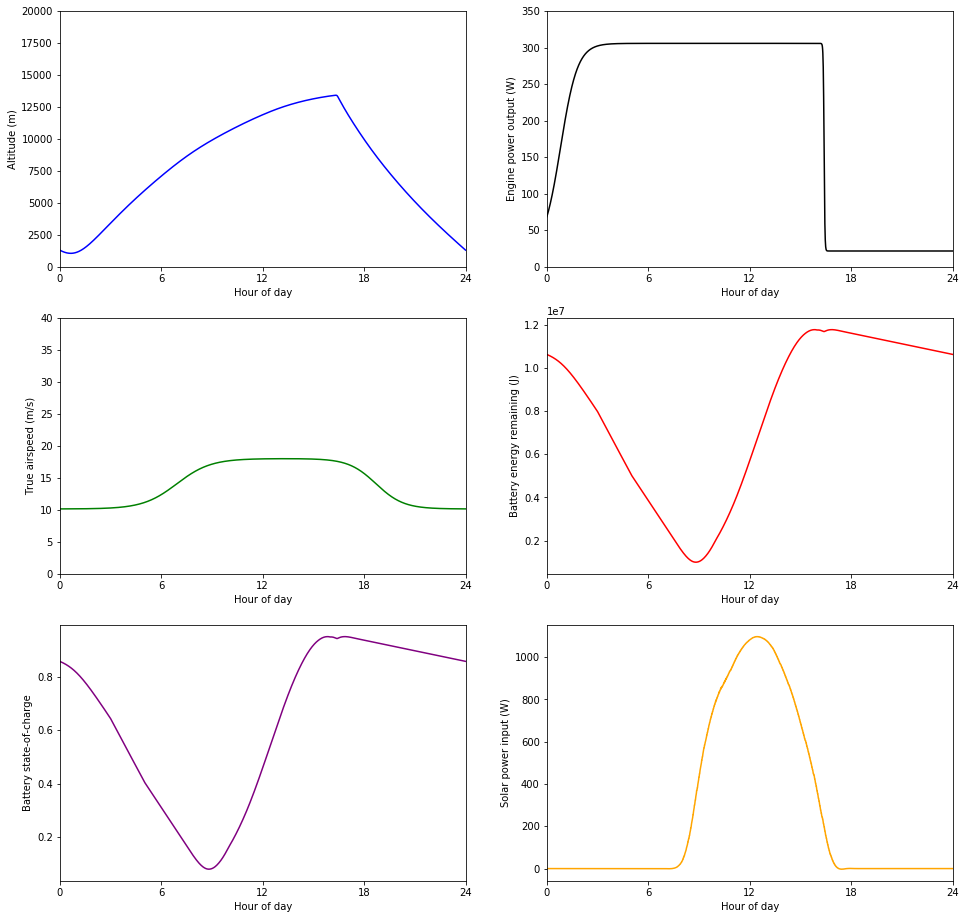

In [11]:
plane_no = 0
result, detail = compute_flight(**planes.iloc[plane_no].loc[opt_vars])
detail_df = pd.DataFrame.from_dict(dict(detail)).set_index('time').sort_index()

# Summary stats
skip_vars = ['a2', 'a3', 'a4', 'a5', 'a6', 'e2', 'e3', 'e4', 'e5', 'e6']
renames = {
    'e1': 'normal_engine_power',
    'a1': 'normal_airspeed'
}
display(planes.iloc[plane_no].rename(renames).rename('Plane {}'.format(plane_no)).drop(skip_vars))

# Plots of day
f, axarr = plt.subplots(3, 2, figsize=(16,16))
y_labels = {
        'altitude': 'Altitude (m)',
        'engine_power': 'Engine power output (W)',
        'airspeed': 'True airspeed (m/s)',
        'battery_energy': 'Battery energy remaining (J)',
        'battery_SOC': 'Battery state-of-charge',
        'solar_power': 'Solar power input (W)',
}
colors = ['blue', 'black', 'green', 'red', 'purple', 'orange']
for i, col in enumerate(detail_df):
    ax = axarr.flatten()[i]
    detail_df[col].plot(ax=ax, color=colors[i])
    ax.set_ylabel(y_labels[col])
    ax.set_xlabel('Hour of day')
    ax.set_xlim(0, 24)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_xticks([0, 6, 12, 18, 24])
    if col == 'altitude':
        ax.set_ylim(0, 20000)
    elif col == 'engine_power':
        ax.set_ylim(0, 350)
    elif col == 'airspeed':
        ax.set_ylim(0, 40)